* [1.Préparation des données](#pd)
* [2.Bag of word - Tf-idf](#bow)
* [3.Word embedding](#we)
 * [3.1.Word2Vec](#wv)
 * [3.2.Bert](#bert)
 * [3.3.USE](#use)


In [25]:
#!pip install tensorflow
#!pip install gensim
#!pip install transformers
#!pip install sentencepiece
#!pip install tensorflow_hub
#!pip install tensorflow_text
#!pip install spellchecker
#!pip install pyspellchecker
#!pip install textblob
#!pip  install pyLDAvis


# 1.Préparation des données <a class="anchor" id="pd"></a>

## Préparation du dataset et filtres de données

In [26]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings("ignore")

In [27]:
# Fichier des tweets à récupérer sur : https://www.kaggle.com/crowdflower/twitter-airline-sentiment?select=Tweets.csv

path = 'Flipkart/' # à adapter = répertoire de stockage du dataset
data_T0 = pd.read_csv(path + "flipkart_com-ecommerce_sample_1050.csv")
print(data_T0.shape)

(1050, 15)


In [28]:
data_T0.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


In [29]:
data_T0['product_category_tree']=data_T0['product_category_tree'].str.replace('[', '').str.replace('"', '')
#Splitting category column 
data_T0['main_category']=data_T0['product_category_tree'].str.split('>>', expand=True)[0]
data_T0['main_category'].value_counts()

Home Furnishing                150
Baby Care                      150
Watches                        150
Home Decor & Festive Needs     150
Kitchen & Dining               150
Beauty and Personal Care       150
Computers                      150
Name: main_category, dtype: int64

In [30]:
print("Number of main category ",data_T0['main_category'].nunique())

Number of main category  7


In [31]:
data_T0['main_category'].value_counts()

Home Furnishing                150
Baby Care                      150
Watches                        150
Home Decor & Festive Needs     150
Kitchen & Dining               150
Beauty and Personal Care       150
Computers                      150
Name: main_category, dtype: int64

In [32]:
def second_category(value):
    ''' extract the sub category of the product'''
    try:
        return value.split('>>')[1]
    except IndexError:
        return 'None'
def third_category(value):
    ''' extract the sub sub category of the product'''
    
    try:
        return value.split('>>')[2]
    except IndexError:
        return 'None'

In [33]:
data_T0['sub_category']=data_T0['product_category_tree'].apply(second_category)
data_T0['sub-sub_category']=data_T0['product_category_tree'].apply(third_category)
print("Number of sub category ",data_T0['sub_category'].nunique())
print("Number of sub sub category ",data_T0['sub-sub_category'].nunique())

Number of sub category  63
Number of sub sub category  247


In [34]:
cols=['description','product_name','image','main_category']
data1=data_T0[cols]


In [35]:
data1.head(2)

,description,product_name,image,main_category
0,Key Features of Elegance Polyester Multicolor ...,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care


<AxesSubplot: >

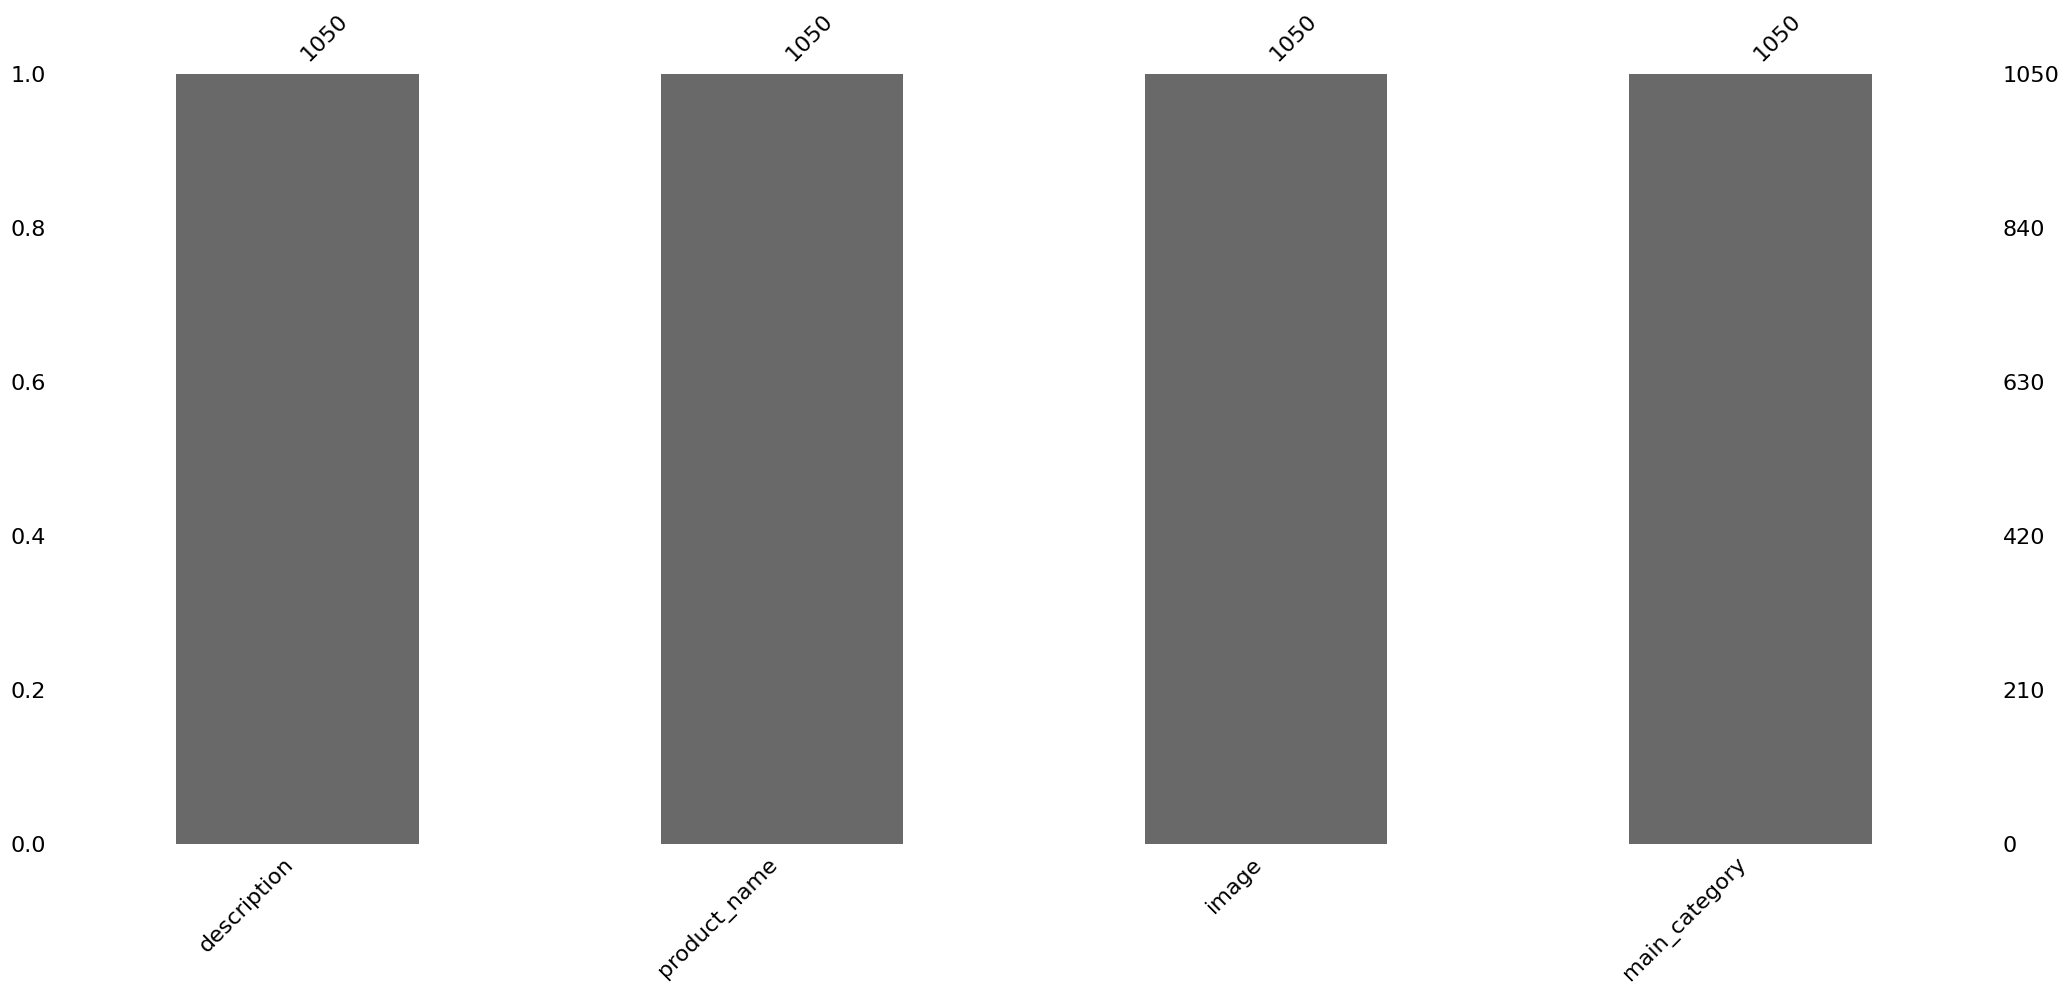

In [36]:
msno.bar(data1)

In [37]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from spellchecker import SpellChecker
from textblob import TextBlob

def tokenizer_fct(sentence) :
    '''tokenize a sentence'''
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    '''filter  a sentence based on a given stop words list'''
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    '''lower words in  sentence if word not start with @ and http'''
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    '''lemmatization(word base)'''
    lemmatizer = WordNetLemmatizer()    
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

#stemming
def stem_fct(list_words) :
    """ stemming """
    porter = PorterStemmer()    
    stem_w = [porter.stem(w) for w in list_words]
    return stem_w
#spell checking
def spell_fct1(list_words):
    """spell checking on english text"""
    spell = SpellChecker()
    spell_w = [spell.correction(w) for w in list_words]
    return spell_w
def spell_fct(list_words):
    """spell checking on english text"""
    
    spell_w = [TextBlob(w) for w in list_words]
    return spell_w

def transform_bow_fct(desc_text) :
    '''preparing text for bag of words (Countvectorizer and Tf_idf, Word2Vec):tokenization+spell check+stop word filtering+lower case'''
    word_tokens = tokenizer_fct(desc_text)       
    sw = stop_word_filter_fct(word_tokens)    
    lw = lower_start_fct(sw)
    
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Preparing text for  bag of words with lemmatization
def transform_bow_lem_fct(desc_text) :
    '''preparing text for bag of words (Countvectorizer and Tf_idf, Word2Vec):
           tokenization+spell check+stop word filtering+
           lower case+lemmatization'''
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)    
    lw = lower_start_fct(sw)
    
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Preparing text bag of words with lemmatization+stemming
def transform_bow_lem_stem_fct(desc_text) :
    '''preparing text for bag of words (Countvectorizer et Tf_idf, Word2Vec):
           tokenization+spell check+stop word filtering+
           lower case+lemmatization+stemming'''
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)    
    lw = lower_start_fct(sw)

    lem_w = lemma_fct(lw) 
  
    stem_w = stem_fct(lem_w)
  
    transf_desc_text = ' '.join(stem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    '''preparing text for deep learning (USE and BERT):tokenization+spell check+lower case
       lower case+lemmatization'''
    word_tokens = tokenizer_fct(desc_text)
    #sw = stop_word_filter_fct(word_tokens) 
    lw = lower_start_fct(word_tokens)
    
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

#word frequency
def most_frequent_words_fct(sentence):
    """list the 10 most frequent words"""
    sentence_tokens = word_tokenize(sentence)
    word_frequency = nltk.FreqDist(sentence_tokens)
    return(word_frequency.most_common(10))


In [38]:
data1.columns

Index(['description', 'product_name', 'image', 'main_category'], dtype='object')

In [40]:
#Description preparation for bag of words
data1['description_bow'] = data1['description'].apply(lambda x : transform_bow_fct(x))#tokonization+lower case+stop words
data1['description_bow_lem_stem'] = data1['description'].apply(lambda x : transform_bow_lem_stem_fct(x))#tokonization+lower case+stop words+lemmatization+stemming
#préparation du texte pour le Deep learning
data1['description_dl'] = data1['description'].apply(lambda x : transform_dl_fct(x))#tokonization+lower case


In [42]:


data1['most_frequent_10_w_description_bow_lem_stem']=\
   data1['description_bow_lem_stem'].apply(lambda x : most_frequent_words_fct(x))

In [43]:
data1['most_frequent_10_w_description_bow_lem_stem'].sample(5)

845    [(feetj, 2), (trouser, 2), (for, 2), (onli, 2)...
36     [(the, 12), (fragranc, 8), (and, 8), (with, 6)...
228    [(showpiec, 4), (lal, 2), (have, 2), (rajastha...
766    [(bottl, 7), (nutcas, 5), (design, 5), (water,...
654    [(towel, 2), (buy, 1), (the, 1), (intellect, 1...
Name: most_frequent_10_w_description_bow_lem_stem, dtype: object

In [31]:
#product name  preparation for bag of words
data1['pdtname_bow'] = data1['product_name'].apply(lambda x : transform_bow_fct(x))#tokonization+lower case+stop words
data1['pdtname_bow_lem_stem'] = data1['product_name'].apply(lambda x : transform_bow_lem_stem_fct(x))#tokonization+lower case+stop words+lemmatization+stemming
#préparation du texte pour le Deep learning
data1['pdtname_dl'] = data1['product_name'].apply(lambda x : transform_dl_fct(x))#tokonization+lower case


In [137]:
data1.columns

Index(['description', 'product_name', 'image', 'main_category',
       'description_bow', 'description_bow_lem_stem', 'description_dl',
       'pdtname_bow', 'pdtname_bow_lem_stem', 'pdtname_dl'],
      dtype='object')

In [32]:
data1.to_csv("data_product.csv",index=False)

# Préparation commune des traitements

In [59]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging

logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere


## Lecture dataset

In [47]:
data_T = pd.read_csv("data_product.csv")
print(data_T.shape)

(1050, 10)


In [48]:
l_cat = list(set(data_T['main_category']))
print("catégories : ", l_cat)


catégories :  ['Kitchen & Dining ', 'Beauty and Personal Care ', 'Computers ', 'Baby Care ', 'Home Decor & Festive Needs ', 'Watches ', 'Home Furnishing ']


In [49]:
#convert main_category (target) to int
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_cat_num = le.fit_transform(data_T['main_category'])
set(y_cat_num)

{0, 1, 2, 3, 4, 5, 6}

In [96]:
data_T.columns

Index(['description', 'product_name', 'image', 'main_category',
       'description_bow', 'description_bow_lem_stem', 'description_dl',
       'pdtname_bow', 'pdtname_bow_lem_stem', 'pdtname_dl'],
      dtype='object')

In [24]:
from nltk.tokenize import sent_tokenize, word_tokenize
data_T['length_bow'] = data_T['description_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", data_T['length_bow'].max())
data_T['length_bow_lem_stem'] = data_T['description_bow_lem_stem'].apply(lambda x : len(word_tokenize(x)))
print("max length bow_lem_stem : ", data_T['length_bow_lem_stem'].max())
data_T['length_dl'] = data_T['description_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", data_T['length_dl'].max())
#print("most frequent 10 words in description bow (bag of words) ",frequent_words(data_T['description_bow']))
#(print('*'*10))
#print("most frequent 10 words in description bow_lem (bag of words+lemmatization+stemming) ",frequent_words(data_T['description_bow_lem_stem']))
#(print('*'*10))
#print("most frequent 10 words in description dl (deep leaning) ",frequent_words(data_T['description_dl']))


NameError: name 'data_T' is not defined

## Fonctions communes

In [50]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    '''
    -Calcul Tsne+
    -détermination des clusters +
    -calcul ARI entre vrais catégorie et n° de clusters
    '''
    time1 = time.time()
    num_labels=len(l_cat)
    print('size',features.shape)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    '''visualisation du Tsne selon les vraies catégories et selon les clusters '''
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Catégorie principale")
    plt.title('Représentation des produits par  catégories principales réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')
    
    plt.show()
    print("ARI : ", ARI)


# 2.Bag of word - Tf-idf <a class="anchor" id="bow"></a>
**a.Bag of words**(Le One-Hot) consite à créer un dictionnaire avec tous les mots qui apparaissent dans nos phrases nettoyées.

-Ce dictionnaire est en fait un tableau où chaque colonne représente un mot et chaque ligne représente une phrase.

-Si tel mot apparaît dans tel phrase, on met une valeur de 1 dans l’élément du tableau, sinon on met une valeur de 0.

-On aura donc un tableau composé uniquement de 0 et de 1.
<br>
**b.TF_IDF** consiste àcompter le nombre d’occurrences des tokens présents dans le corpus pour chaque texte, que l’on divise ensuite par le nombre d’occurrences total de ces même tokens dans tout le corpus.

## Préparation sentences

In [51]:
# création du bag of words (CountVectorizer et Tf-idf)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#Convert a collection of text documents to a matrix of token counts.
cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)#max_df:maximum document frequency.
#Convert a collection of raw documents to a matrix of TF-IDF features
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat1 = 'description_bow_lem_stem'
feat2='pdtname_bow_lem_stem'
cv_fit = cvect.fit(data_T[feat2])#Learn a vocabulary dictionary of all tokens in data_T[feat2]

ctf_fit = ctf.fit(data_T[feat2])
# Encode the Document
cv_transform = cvect.transform(data_T[feat1]) #Extract token counts out of data_T[feat1,feat2] using the vocabulary fitted with fit
cv_transform = cvect.transform(data_T[feat2]) 

ctf_transform = ctf.transform(data_T[[feat1]])  
ctf_transform = ctf.transform(data_T[feat2]) 

In [94]:
print(list(cvect.get_feature_names())[0:10])

['001', '005', '006', '011', '01433cmgi', '01727lpln', '01741lpln', '01784bmli', '03918cmli', '04615cmgi']


In [72]:
print(ctf.get_feature_names_out())

['001' '005' '006' ... 'zone' 'zora' 'zyxel']


In [99]:
cv_transform


<1050x2110 sparse matrix of type '<class 'numpy.int64'>'
	with 18583 stored elements in Compressed Sparse Row format>

In [139]:
#print( cvect.get_feature_names())

In [101]:
#collection of words in the sparse matrix.
# Printing the identified Unique words along with their indices
print("First 8 Vocabulary when using Countvectorizer: ", list(cvect.vocabulary_.items())[0:8])


First 8 Vocabulary when using Countvectorizer:  [('eleg', 739), ('polyest', 1519), ('multicolor', 1309), ('abstract', 238), ('eyelet', 779), ('door', 693), ('curtain', 628), ('sathiya', 1698)]


In [102]:
ctf_transform

<1050x2110 sparse matrix of type '<class 'numpy.float64'>'
	with 6333 stored elements in Compressed Sparse Row format>

In [75]:

print("8 first Vocabulary when using tfidtvectorizer:\n ",list(ctf.vocabulary_.items())[0:8] )

8 first Vocabulary when using tfidtvectorizer:
  [('eleg', 739), ('polyest', 1519), ('multicolor', 1309), ('abstract', 238), ('eyelet', 779), ('door', 693), ('curtain', 628), ('sathiya', 1698)]


## Exécution des modèles

In [103]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)


CountVectorizer : 
-----------------
size (1050, 2110)
ARI :  0.3635 time :  7.0

Tf-idf : 
--------
size (1050, 2110)
ARI :  0.5558 time :  6.0


## Graphiques

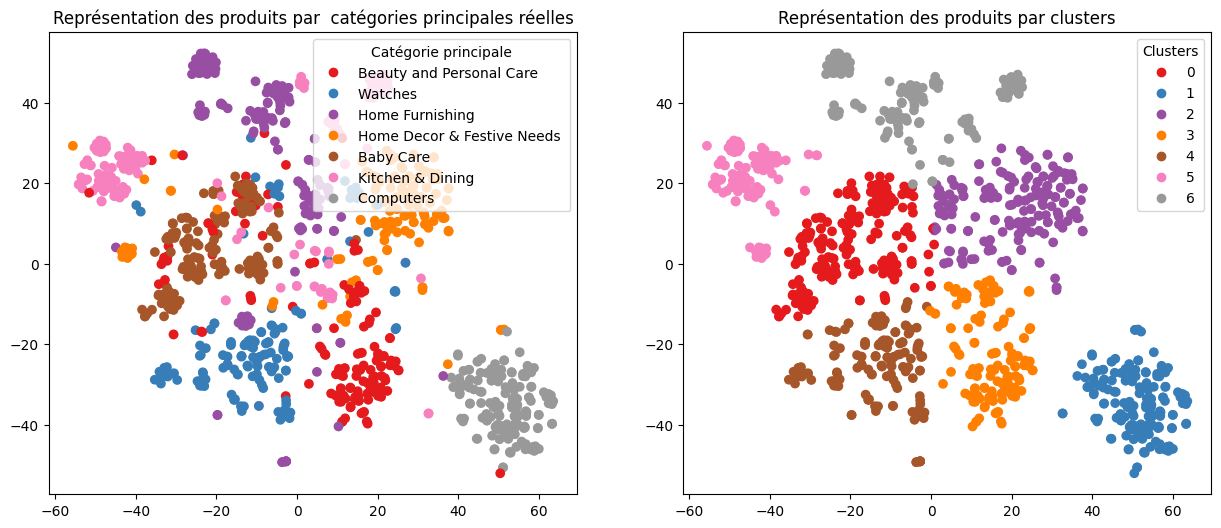

ARI :  0.5558


In [104]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [52]:
# Création d'un dataframe avec les résultats

tfidf = pd.DataFrame(ctf_transform.toarray(), columns = ctf.get_feature_names())

tfidf.head()

,001,005,006,011,01433cmgi,01727lpln,01741lpln,01784bmli,03918cmli,04615cmgi,...,youth,yuva,yve,zaicu,zero,zikrak,zingalalaa,zone,zora,zyxel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# Mot ayant le score TF-IDF maximum par description

tfidf['topic'] = tfidf.apply(lambda row : tfidf.columns[row.argmax()], axis=1)

tfidf['topic']

0          eleg
1       sathiya
2       eurospa
3       santosh
4        jaipur
         ...   
1045      empow
1046    sticker
1047       film
1048    sticker
1049    uberlyf
Name: topic, Length: 1050, dtype: object

In [56]:
new_top = tfidf['topic'].value_counts().head(7).to_frame()
#new_top.style.background_gradient(cmap='Reds')
new_top

,topic
usb,10
raymond,7
sticker,6
led,4
jewelleri,4
wow,3
prithish,3


## Topic modeling using LDA (Pas encore finaliser)

- la matrice des topicsLDA convertit lq  matrice document-word en deux autres matrices :  Document Term matrix and Topic Word
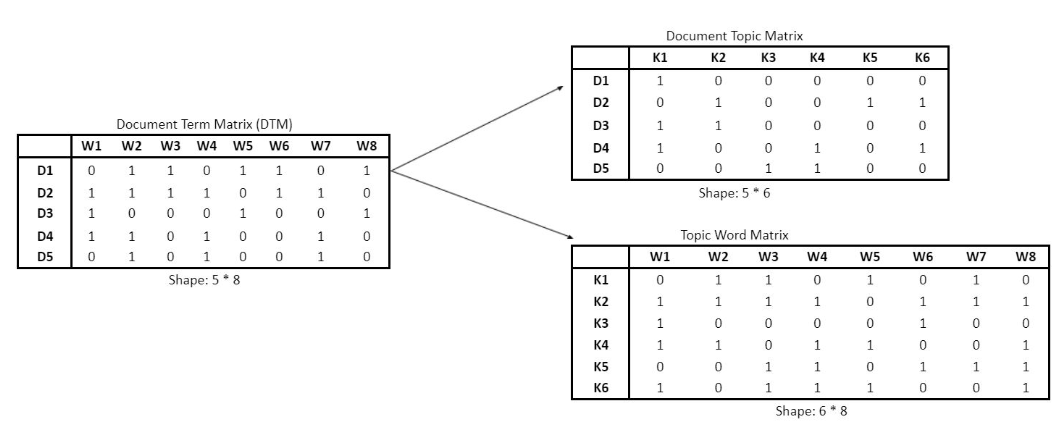
- The end goal of LDA is to find the most optimal representation of the Document-Topic matrix and the Topic-Word matrix to find the most optimized Document-Topic distribution and Topic-Word distribution.

In [59]:
# Créer le modèle LDA
from sklearn.decomposition import LatentDirichletAllocation
n_topics=7
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda.fit(cv_transform)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=7, random_state=0)

In [64]:
# Affichage des 10 top mots par sujet

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words= 10
display_topics(lda, cvect.get_feature_names(), 10)

Topic 0:
showpiec cotton usb towel bath set bedsheet hub fan handicraft
Topic 1:
led usb light cream vitamin kit massag fruit oxyglow flexibl
Topic 2:
sticker singl vinyl larg medium wallmantra quilt comfort multicolor extra
Topic 3:
set combo ceram mug print shape pad skin mous laptop
Topic 4:
polyest curtain eyelet aroma comfort door design self cell brown
Topic 5:
watch analog babi men girl boy woman maximum sonata dress
Topic 6:
cover cushion router wireless link print band dual asu dsl


In [63]:
data_T.main_category.unique()

array(['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers '], dtype=object)

- Le découpage proprosé par l'algorithme LDA ne correspond pas exactement tout à fait à nos labels.
- Par exemple, on peut remarquer que les topics sont mélanger

In [11]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 5

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
W1=lda.fit_transform(ctf_transform)
H1=lda.components_
W1

array([[0.05527874, 0.05599619, 0.05526723, 0.77818807, 0.05526978],
       [0.06802394, 0.06800266, 0.72781455, 0.06812533, 0.06803352],
       [0.06000105, 0.05975563, 0.75952451, 0.06061644, 0.06010236],
       ...,
       [0.78985953, 0.05259869, 0.0525163 , 0.05250965, 0.05251582],
       [0.7279417 , 0.06801388, 0.06801478, 0.06801527, 0.06801437],
       [0.73210737, 0.06697337, 0.06697428, 0.06697197, 0.06697301]])

In [12]:
num_words=15
vocab=np.array(ctf.get_feature_names())
top_words = lambda t:[vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics=[' '.join(t) for t in topic_words]
topics

['sticker showpiec vinyl larg medium wallmantra cover cushion extra uberlyf wall usb handicraft nutrit cream',
 'watch analog men woman sonata maximum boy digit gold time girl perucci timewel 1100 combo',
 'towel cotton led bath light usb jewelleri bulb pack flexibl set portabl steel spf cold',
 'set ceram mug combo comfort print shape pad skin mous polyest curtain eyelet doubl singl',
 'babi girl boy dress shirt set print kadhai combo cell casual mini batteri gather klub']

In [16]:
colnames = ["Topic" + str(i) for i in range(lda.n_components)]
docnames = ["Doc" + str(i) for i in range(len(data_T.description_bow_lem_stem))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.06,0.06,0.06,0.78,0.06,3
Doc1,0.07,0.07,0.73,0.07,0.07,2
Doc2,0.06,0.06,0.76,0.06,0.06,2
Doc3,0.41,0.05,0.05,0.44,0.05,3
Doc4,0.05,0.05,0.05,0.79,0.05,3
...,...,...,...,...,...,...
Doc1045,0.78,0.06,0.06,0.06,0.06,0
Doc1046,0.73,0.07,0.07,0.07,0.07,0
Doc1047,0.79,0.05,0.05,0.05,0.05,0
Doc1048,0.73,0.07,0.07,0.07,0.07,0


In [14]:
feat1

'description_bow_lem_stem'

# 3. Word embedding <a class="anchor" id="we"></a>
<br>
**BOW et TF_IDF**:<br>
L’efficacité de ces méthodes diffère selon le cas d’application. Toutefois, elles présentent deux principales limites :<br>
-Plus le vocabulaire du corpus est riche, plus la taille des vecteurs est grande, ce qui peut représenter un problème pour les modèles d’apprentissage utilisées dans l’étape suivante.
-Le comptage d’occurrence des mots ne permet pas de rendre compte de leur agencement et donc du sens des phrases.<br>
Il existe une autre approche qui permet de remédier à ces problèmes :  Word Embedding.<br>
**Word Embedding**<br>
-Elle consiste à construire des vecteurs de taille fixe qui prennent en compte le contexte dans lequel se trouvent les mots. 
## 3.1.Word2Vec <a class="anchor" id="wc"></a>

In [83]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding.

## 3.1 Word2Vec<a class="anchor" id="wv"></a>

In [166]:
#création du modèle word2vec
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = data_T['description_bow_lem_stem'].to_list()
#Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long.
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [167]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4175
Word2Vec trained


In [168]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4176


## Création de la matrice d'embedding

In [170]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4176, 300)


## Création du modèle d'embedding

In [171]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           1252800   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,252,800
Trainable params: 1,252,800
Non-trainable params: 0
_________________________________________________________________


## Exécution du modèle

In [172]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 4s 2ms/step


(1050, 300)

In [173]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.2153 time :  8.0


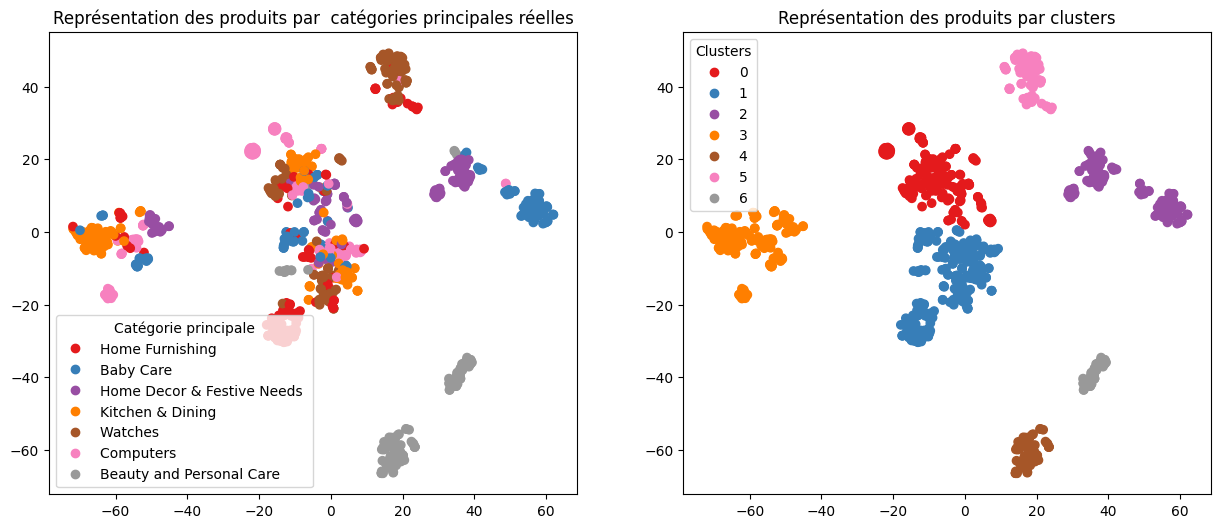

ARI :  0.2153


In [174]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## 3.2.BERT<a class="anchor" id="bert"></a>

In [177]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [179]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.10.0
2.10.0
Num GPUs Available:  0
True


## Fonctions communes

In [180]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

## BERT HuggingFace

### 'bert-base-uncased'

In [182]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['description_dl'].to_list()

In [183]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 1s 597ms/step
temps traitement :  77.0


In [184]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.3265 time :  9.0


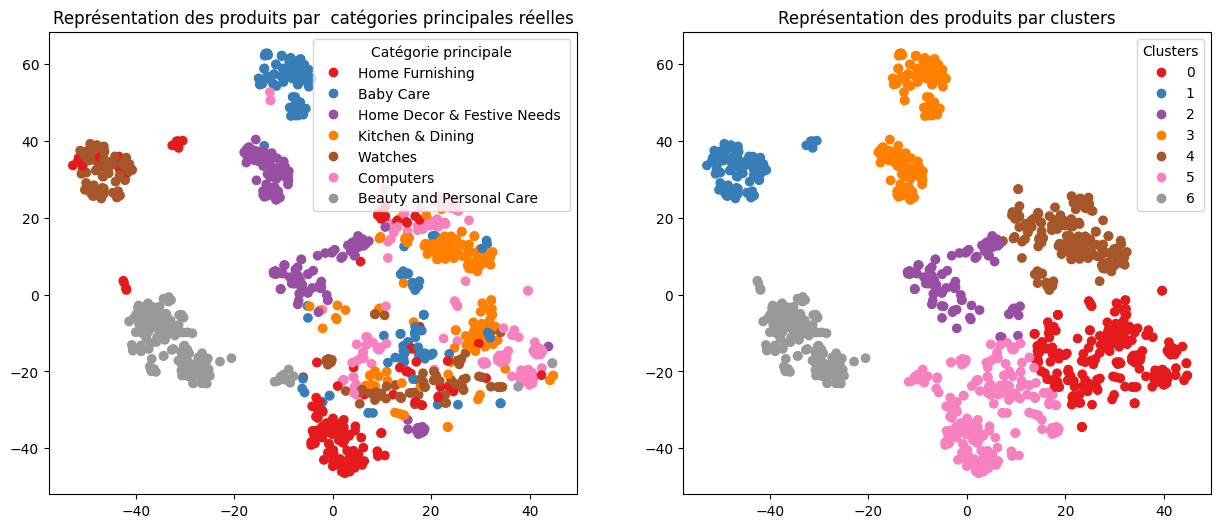

ARI :  0.3265


In [185]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### 'cardiffnlp/twitter-roberta-base-sentiment'
* Modèle pré-entraîné sur des tweets pour l'analyse de sentiment = particulièrement adapté au contexte

In [186]:
max_length = 64
batch_size = 10
model_type = 'cardiffnlp/twitter-roberta-base-sentiment'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['description_dl'].to_list()

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [187]:
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

1/1 [==============================] - 1s 615ms/step
temps traitement :  80.0


In [188]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.2245 time :  9.0


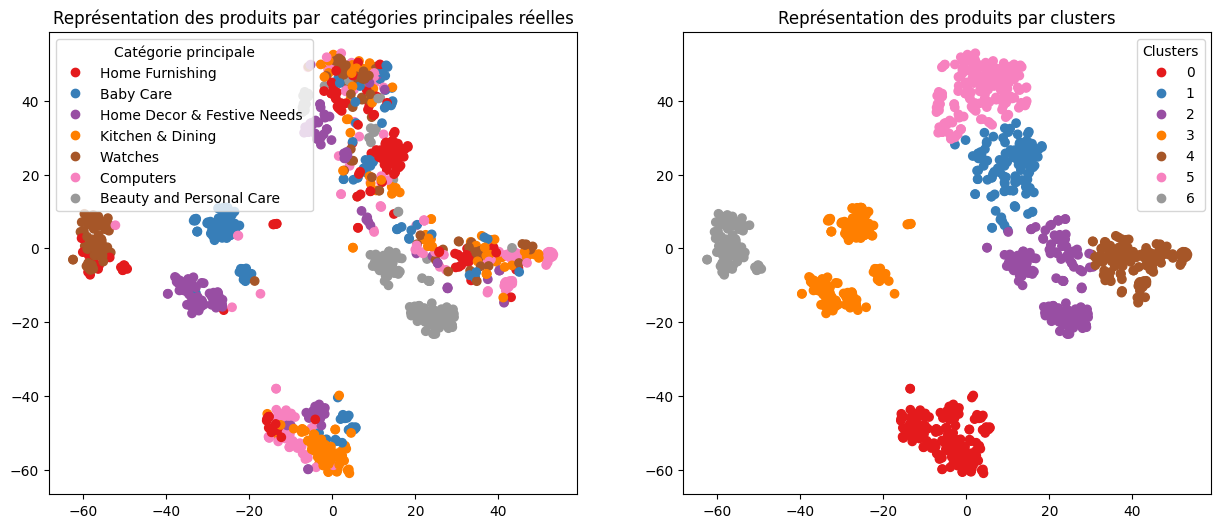

ARI :  0.2245


In [189]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## BERT hub Tensorflow

In [194]:
import tensorflow_hub as hub
import tensorflow_text 

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [196]:
sentences = data_T['description_dl'].to_list()

In [197]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

temps traitement :  75.0


In [198]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.3158 time :  9.0


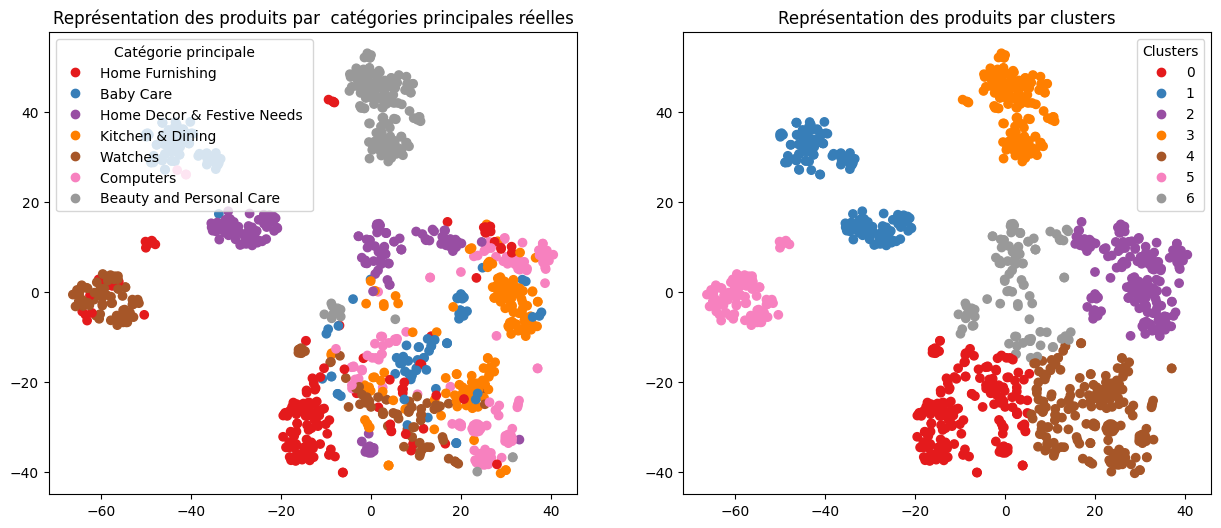

ARI :  0.3158


In [199]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## 3.3. USE - Universal Sentence Encoder <a class="anchor" id="use"></a>

In [200]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [201]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.10.0
2.10.0
Num GPUs Available:  0
True


In [202]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [205]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [206]:
batch_size = 10
sentences = data_T['description_dl'].to_list()

In [207]:
features_USE = feature_USE_fct(sentences, batch_size)

In [36]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.7315 time :  29.0


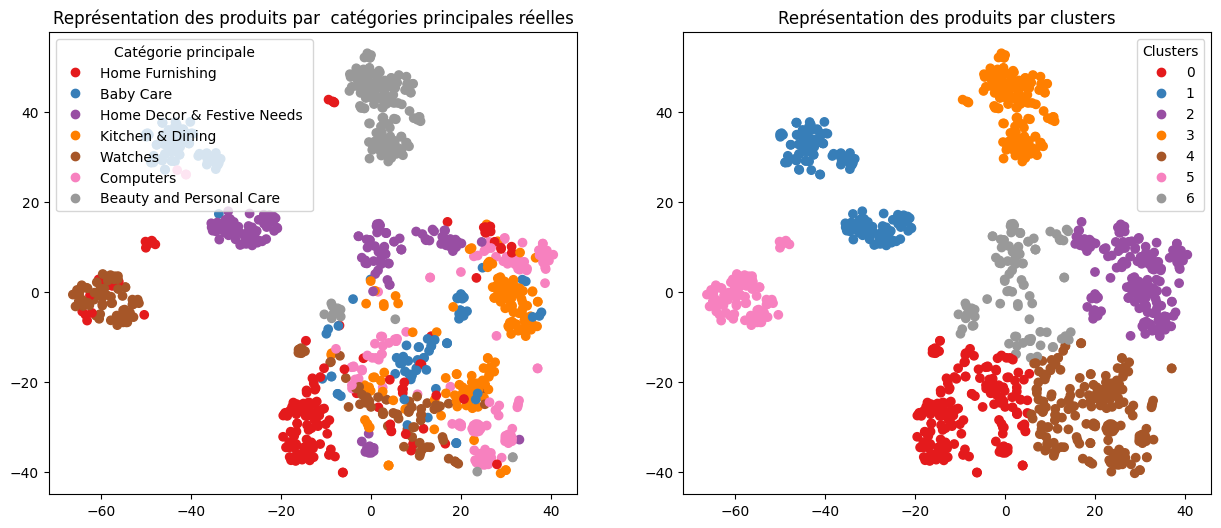

ARI :  0.3158


In [208]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)